<a href="https://colab.research.google.com/github/TamerKaratekin/healthcare/blob/main/Explainable_AI_(Glass_Box)_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Strategy: "Glass Box" AI for Clinical Decision Support

**Author:** Tamer Karatekin  
**Objective:**  
Develop a Clinical Decision Support (CDS) prototype that not only predicts disease risk (Diabetes) but explains the *reasoning* behind the prediction.

**Strategic Context:**  
In Healthcare IT, accuracy is not enough. To secure clinician adoption and FDA approval (Software as a Medical Device - SaMD), AI models must be interpretable. This project implements an **Explainable Boosting Machine (EBM)**—a modern implementation of the **GA2M** architecture I researched at MIT—to provide feature-level transparency.

**Tech Stack:**
*   **Model:** `InterpretML` (Microsoft's EBM).
*   **Validation:** `Scikit-Learn`.
*   **Visualization:** `Matplotlib` (Static plots for easy reporting).

**Cell 2: Install & Import (Code)**

In [2]:
# Install Microsoft's InterpretML (The industry standard for EBMs)
!pip install -q interpret

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

# Configuration for static plots (Prevents GitHub Widget Errors)
plt.style.use('ggplot')
print("✅ Environment Ready: InterpretML & Scikit-Learn loaded.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 64.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 19.5 MB/s eta 0:00:00
✅ Environment Ready: InterpretML & Scikit-Learn loaded.


**Cell 3: Data Ingestion (Code)**

In [3]:
# Loading the standard Pima Indians Diabetes dataset
# PM Note: In a real OCI environment, this would pull from an Autonomous Database.

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BP', 'SkinThickness', 'Insulin', 'BMI', 'Pedigree', 'Age', 'Outcome']
df = pd.read_csv(url, names=column_names)

# Split Data (80% Training / 20% Validation)
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📊 Dataset Loaded: {len(df)} Patient Records.")
df.head()

📊 Dataset Loaded: 768 Patient Records.


,Pregnancies,Glucose,BP,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Cell 4: Train the "Glass Box" Model (Code)**


In [6]:
# Training an EBM (Explainable Boosting Machine).
# This is a tree-based GA2M model. It is highly accurate but fully transparent.

ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)

# PM Insight: Validate performance before deploying.
# We check AUC (Area Under Curve) which is standard for medical diagnostics.
probs = ebm.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)

print(f"🚀 Model Trained. Performance (AUC): {auc:.3f}")
print("Note: An AUC > 0.80 is generally considered very good for this dataset.")

🚀 Model Trained. Performance (AUC): 0.812
Note: An AUC > 0.80 is generally considered very good for this dataset.


**Cell 5: Global Explainability - "What drives the disease?" (Code)**

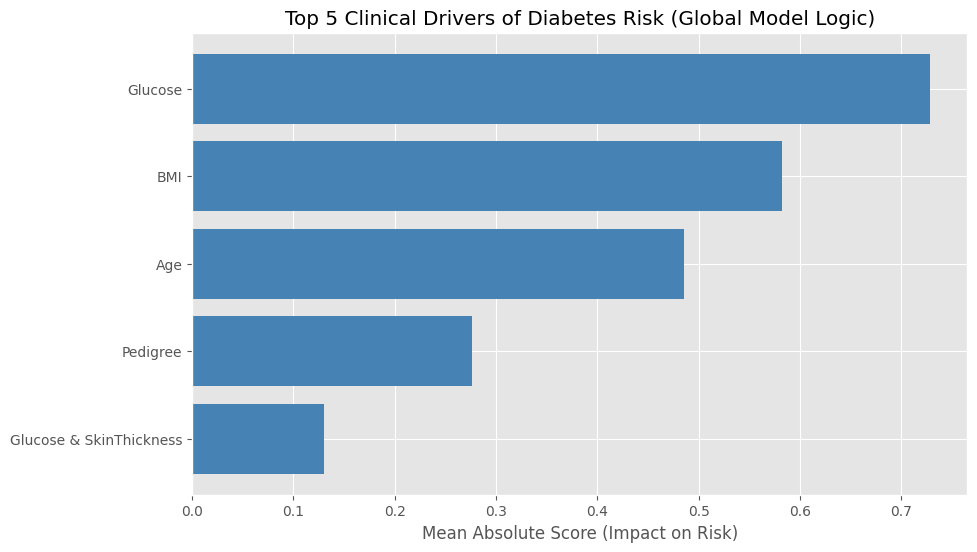

In [7]:
# PM Question: "Doctor, what are the biggest risk factors in our population?"
# We extract the model's internal logic to answer this.

ebm_global = ebm.explain_global()
data = ebm_global.data()
features = data['names']
importances = data['scores']

# Visualize Top Risk Factors
# Using Matplotlib to ensure it renders on GitHub (Interactive widgets often break)
indices = np.argsort(importances)[-5:] # Top 5 features

plt.figure(figsize=(10, 6))
plt.title("Top 5 Clinical Drivers of Diabetes Risk (Global Model Logic)")
plt.barh(range(len(indices)), np.array(importances)[indices], color='steelblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Mean Absolute Score (Impact on Risk)")
plt.show()

**Cell 6: Local Explainability - "Why THIS patient?" (Code)**

👤 Patient Case #10
🩸 Actual Outcome: Diabetic
🤖 AI Risk Score: 19.9%
------------------------------


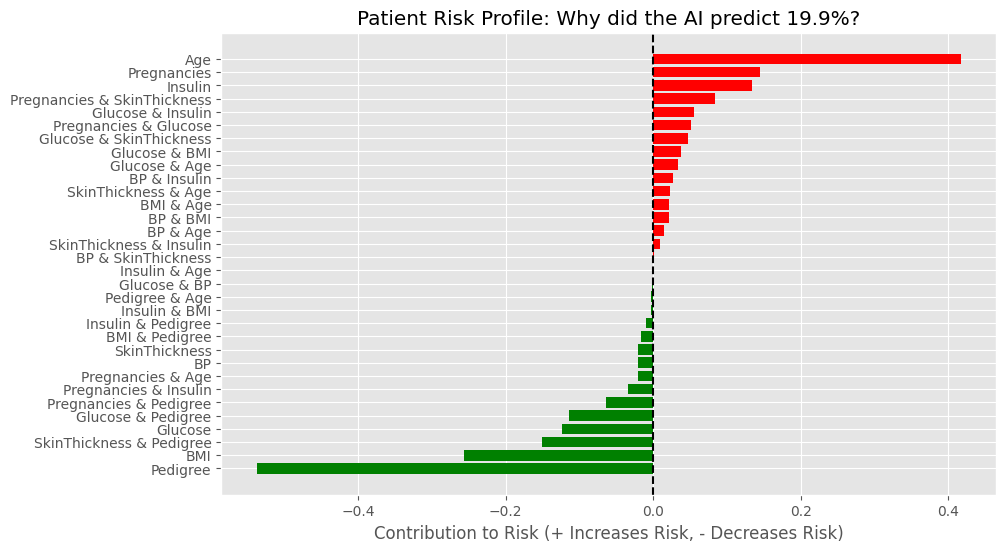

In [8]:
# PM Scenario: A clinician is reviewing a specific patient (Patient #10).
# The AI flags them as High Risk. The doctor asks: "Why?"

patient_index = 10
patient_data = X_test.iloc[[patient_index]]
actual_label = y_test.iloc[patient_index]
prediction_prob = ebm.predict_proba(patient_data)[0, 1]

print(f"👤 Patient Case #{patient_index}")
print(f"🩸 Actual Outcome: {'Diabetic' if actual_label==1 else 'Healthy'}")
print(f"🤖 AI Risk Score: {prediction_prob:.1%}")
print("-" * 30)

# Extract Local Explanation
ebm_local = ebm.explain_local(patient_data, y_test.iloc[[patient_index]])
local_data = ebm_local.data(0)

# Create a DataFrame for the top contributing factors
df_explanation = pd.DataFrame({
    'Feature': local_data['names'],
    'Contribution': local_data['scores']
}).sort_values(by='Contribution', ascending=True) # Sort for chart

# Visualize
plt.figure(figsize=(10, 6))
colors = ['red' if x > 0 else 'green' for x in df_explanation['Contribution']]
plt.barh(df_explanation['Feature'], df_explanation['Contribution'], color=colors)
plt.title(f"Patient Risk Profile: Why did the AI predict {prediction_prob:.1%}?")
plt.xlabel("Contribution to Risk (+ Increases Risk, - Decreases Risk)")
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

**Cell 7: Strategic Conclusion**

### 💡 Product Manager Insights

**1. The "Why" Button:**  
In a production EHR integration (like Epic or Cerner), I would implement the visualization in **Cell 6** as a "Why?" tooltip next to the risk score. This reduces "Alert Fatigue" by allowing doctors to quickly validate the AI's logic (e.g., verifying that "High Glucose" wasn't the driver, but rather age, pregnancies, and insulin).

**2. Bias Audit:**  
Using the Global Explanation (Cell 5), we can audit the model for bias. If variables like "InsuranceType" or "ZipCode" appear as top drivers, we know the model is learning systemic bias rather than clinical pathology, and we must retrain it.

**3. Alignment with Research:**  
This architecture mirrors the **GA2M** approach I detailed in my academic work, bridging the gap between cutting-edge data science and practical, safe clinical deployment.